# **Unsupervised machine learning: k-means**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# path

path = r"D:\0 - Data Analytics\6 - Advanced Analytics & Dashboard Design\UFC Analysis"

# import the dataframe

UFC_df = pd.read_csv(
    os.path.join(path, "02 Data", "Prepared Data", "UFC_cleaned_V2.csv")
)

## **K-means clustering**

### **Clean and encode variables for k-means**

In [2]:
# Re-group decision types in the 'Finish' column
UFC_df["Finish"] = UFC_df["Finish"].replace(
    {"M-DEC": "Decision", "S-DEC": "Decision", "U-DEC": "Decision"}
)

# Encode selected categorical columns
categorical_cols = [
    "Gender",
    "Winner",
    "RedStance",
    "BlueStance",
    "Finish",
    "WeightClass",
]
# Dictionary to store encoders and their mappings
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    UFC_df[col] = le.fit_transform(UFC_df[col])
    label_encoders[col] = le

# Print all encoded mappings
for col, le in label_encoders.items():
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Gender encoding: {'FEMALE': 0, 'MALE': 1}
Winner encoding: {'Blue': 0, 'Red': 1}
RedStance encoding: {'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3}
BlueStance encoding: {'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3, 'Switch ': 4, 'Unknown': 5}
Finish encoding: {'DQ': 0, 'Decision': 1, 'KO/TKO': 2, 'Overturned': 3, 'SUB': 4, 'Unknown': 5}
WeightClass encoding: {'Bantamweight': 0, 'Catch Weight': 1, 'Featherweight': 2, 'Flyweight': 3, 'Heavyweight': 4, 'Light Heavyweight': 5, 'Lightweight': 6, 'Middleweight': 7, 'Welterweight': 8, "Women's Bantamweight": 9, "Women's Featherweight": 10, "Women's Flyweight": 11, "Women's Strawweight": 12}


In [3]:
# Add ReachDiff and StanceDiff
UFC_df["ReachDiff"] = UFC_df["RedReachCms"] - UFC_df["BlueReachCms"]
UFC_df["StanceDiff"] = (UFC_df["RedStance"] == UFC_df["BlueStance"]).astype(int)

# Update the selected features list
selected_features = [
    "Finish",
    "WeightClass",
    "RedStance",
    "BlueStance",
    "TotalFightTimeSecs",
    "FinishRound",
    "RedReachCms",
    "BlueReachCms",
    "RedAge",
    "BlueAge",
    "RedAvgSigStrLanded",
    "BlueAvgSigStrLanded",
    "RedAvgTDPct",
    "BlueAvgTDPct",
    "Gender",
    "Winner",
    "ReachDiff",
    "StanceDiff",
]

# Prepare the data for clustering
clustering_df = UFC_df[selected_features].copy()


### **Elbow method**

In [4]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

In [5]:
# Elbow method to determine optimal number of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

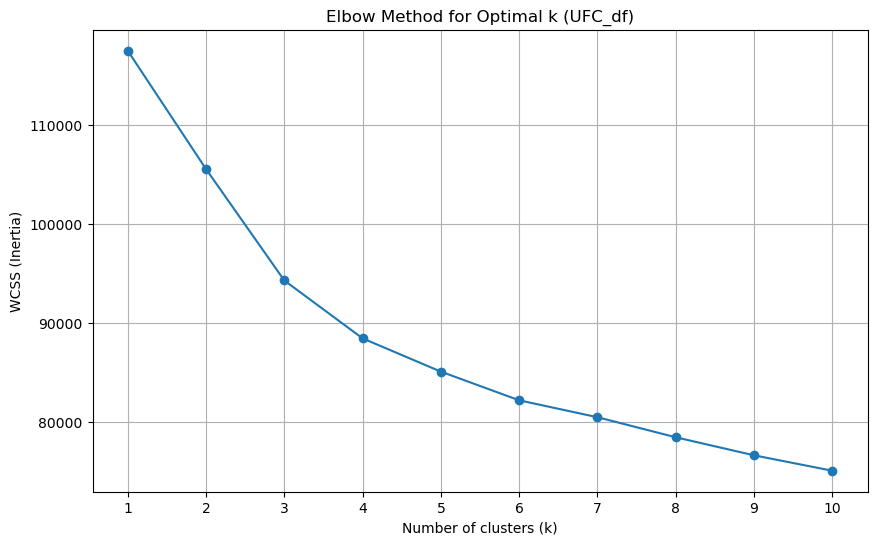

In [6]:
# EPlot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker="o")
plt.title("Elbow Method for Optimal k (UFC_df)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [7]:
# save the plot
plt.savefig(os.path.join(path, "04 Analysis", "Visualizations", "UFC_elbow_plot.png"))

<Figure size 640x480 with 0 Axes>

### Choosing k = 3 Based on the Elbow Method

To determine the optimal number of clusters for K-Means, I used the elbow method, which plots the within-cluster sum of squares (WCSS) against different values of k (number of clusters). 

In the elbow plot, a noticeable drop in WCSS occurs between k = 1 and k = 3. After k = 3, the curve starts to flatten, indicating diminishing returns in reducing WCSS as we increase the number of clusters. This "elbow" shape at **k = 3** suggests that adding more clusters beyond this point does not significantly improve the compactness of the clusters.

For this reason, I selected **k = 3** as the optimal number of clusters. This value provides a good balance between cluster separation and simplicity, and it allows for meaningful interpretation of patterns in the dataset without overfitting.


## Purpose of Clustering

In this step, I'm using K-Means clustering to group UFC fights based on similarities in fighter attributes and fight characteristics. This unsupervised learning technique helps identify patterns that are not immediately obvious—grouping fights that share similar profiles without relying on predefined outcomes.

The clustering includes both numerical and encoded categorical features, such as reach, age, stance, weight class, finish type, and average performance stats (e.g., significant strikes landed, takedown percentage).

By doing this, we aim to:
- Discover natural "types" of fights (e.g., short explosive fights, technical decisions, grappling-heavy bouts)
- Reveal trends in how fights play out based on fighter attributes
- Enable deeper analysis for prediction, visualization, or matchmaking strategy

This step doesn't predict outcomes—it helps **understand the structure** of the fight data by grouping similar events together.


In [8]:
# Apply KMeans clustering with k=3
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
UFC_df["Cluster"] = kmeans.fit_predict(scaled_data)

In [9]:
# Run KMeans and attach cluster labels
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
UFC_df["Cluster"] = kmeans.fit_predict(scaled_data)

## Reach difference Fight Duration

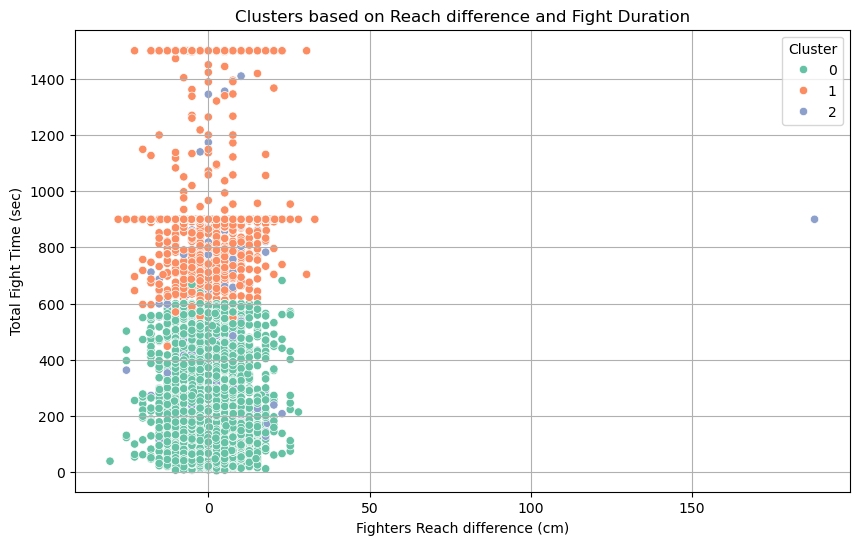

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=UFC_df, x="ReachDiff", y="TotalFightTimeSecs", hue="Cluster", palette="Set2"
)
plt.title("Clusters based on Reach difference and Fight Duration")
plt.xlabel("Fighters Reach difference (cm)")
plt.ylabel("Total Fight Time (sec)")
plt.grid(True)
plt.show()

In [11]:
# save the plot
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "ReachDiff_FightDuration_Kmeans_clusters.png",
    )
)

<Figure size 640x480 with 0 Axes>

### Interpretation 
Based on the KMeans clustering results using **Reach Difference** and **Total Fight Time**, we observe the following insights for each cluster. The **Reach Difference** does not significantly differentiate the clusters, and the primary factor that divides them is **fight duration**.

#### **Cluster 0 (Green)**
- **Reach Difference**: There is no significant reach advantage in this cluster. Fighters have a **balanced reach** between the red and blue corners, with small variations.
- **Total Fight Time**: The fighters in this cluster generally have **shorter fight durations** (below 500 seconds), indicating **quick finishes**, likely by **KO/TKO** or **Submission**.
- **Fighting Style**: Fighters in this cluster may rely more on **aggression** and **speed** to secure **quick finishes**, rather than using reach advantage as a key factor.

#### **Cluster 1 (Orange)**
- **Reach Difference**: Similar to Cluster 0, there is no **significant reach advantage** in this cluster. Reach difference remains balanced.
- **Total Fight Time**: Fighters in this cluster tend to have **moderate fight durations** (between 500 and 1000 seconds). These fights likely end by **decision**.
- **Fighting Style**: The fights here are likely to involve **technical exchanges** without a strong emphasis on reach advantage. **Striking** and **point scoring** could be more prevalent.

#### **Cluster 2 (Blue)**
- **Reach Difference**: Similar to the other clusters, there is no significant reach difference in this group. Fighters have fairly balanced reach.
- **Total Fight Time**: Fighters in this cluster have **longer fight durations**, ranging from 600 to 1200 seconds.
- **Fighting Style**: The longer fight times suggest that these fighters may be involved in more **tactical** or **strategic** fighting, with **wrestling**, **defense**, or **endurance** playing significant roles.

### Key Insights:
- **Reach Difference** is not a significant factor in differentiating the clusters. All clusters show a **balanced reach** between red and blue fighters.
- The primary differentiating factor among the clusters is **fight duration**, with:
  - **Cluster 0 (Green)** having quick finishes (likely KO/TKO or Submission).
  - **Cluster 1 (Orange)** having moderate fight durations that likely end by **decision**.
  - **Cluster 2 (Blue)** having longer, more **tactical** fights.

### Conclusion:
- The **Reach Difference** between fighters does not have a strong influence on the clusters. The **fight duration** is a more meaningful differentiator, with each cluster representing different fighting dynamics based on how long the fights last.


## Stance Difference and Finish

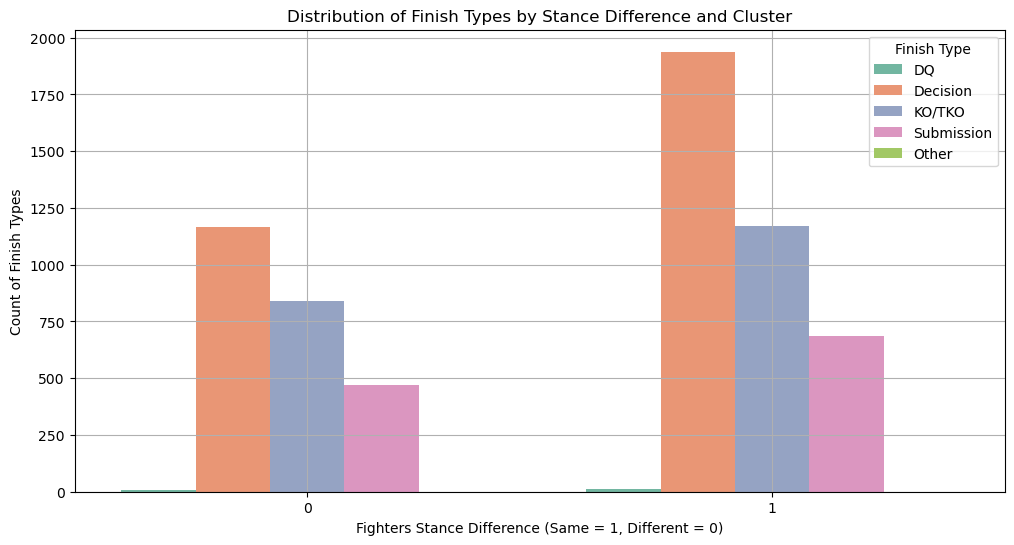

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=UFC_df,
    x="StanceDiff",
    hue="Finish",
    palette="Set2",
    hue_order=[
        0,
        1,
        2,
        4,
        6,
    ],  # Order finish types as: DQ, Decision, KO/TKO, Submission, Other
    order=[0, 1],  # 0 = Different Stance, 1 = Same Stance
)

plt.title("Distribution of Finish Types by Stance Difference and Cluster")
plt.xlabel("Fighters Stance Difference (Same = 1, Different = 0)")
plt.ylabel("Count of Finish Types")
plt.legend(
    title="Finish Type", labels=["DQ", "Decision", "KO/TKO", "Submission", "Other"]
)
plt.grid(True)
plt.show()

In [13]:
# save
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "StanceDiff_FinishType_Kmeans_clusters.png",
    )
)

<Figure size 640x480 with 0 Axes>

## Striking vs takedown

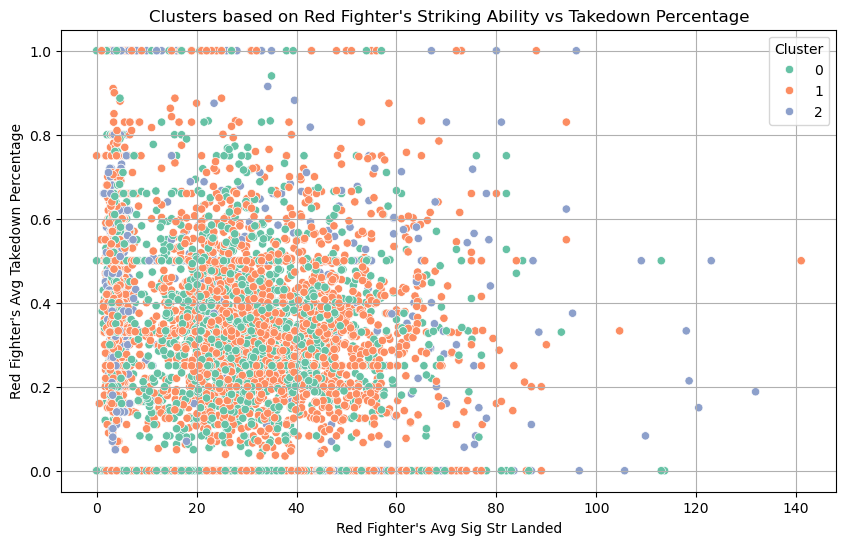

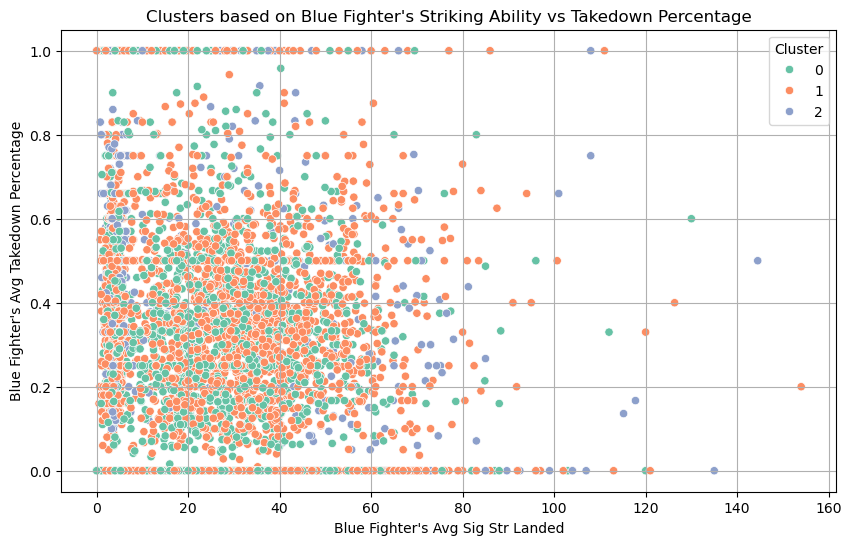

In [14]:
# Plot Striking vs Takedown Percentage for the Red and Blue Fighters
plt.figure(figsize=(10, 6))

# Plot for Red Fighter's Striking vs Takedown Percentage
sns.scatterplot(
    data=UFC_df,
    x="RedAvgSigStrLanded",
    y="RedAvgTDPct",
    hue="Cluster",
    palette="Set2",
    marker="o",
)

plt.title("Clusters based on Red Fighter's Striking Ability vs Takedown Percentage")
plt.xlabel("Red Fighter's Avg Sig Str Landed")
plt.ylabel("Red Fighter's Avg Takedown Percentage")
plt.grid(True)
plt.show()

# Plot for Blue Fighter's Striking vs Takedown Percentage
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=UFC_df,
    x="BlueAvgSigStrLanded",
    y="BlueAvgTDPct",
    hue="Cluster",
    palette="Set2",
    marker="o",
)

plt.title("Clusters based on Blue Fighter's Striking Ability vs Takedown Percentage")
plt.xlabel("Blue Fighter's Avg Sig Str Landed")
plt.ylabel("Blue Fighter's Avg Takedown Percentage")
plt.grid(True)
plt.show()

It looks to have too much dispersion

In [15]:
# Group by clusters and calculate the mean for each feature
cluster_means = UFC_df.groupby("Cluster")[
    ["RedAvgSigStrLanded", "BlueAvgSigStrLanded", "RedAvgTDPct", "BlueAvgTDPct"]
].mean()

print(cluster_means)

         RedAvgSigStrLanded  BlueAvgSigStrLanded  RedAvgTDPct  BlueAvgTDPct
Cluster                                                                    
0                 21.325386            19.657998     0.327919      0.301208
1                 21.919882            21.114352     0.339683      0.323684
2                 19.653275            18.855399     0.377862      0.368925


C:\Users\mauro\AppData\Local\Temp\ipykernel_4452\1772944671.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="RedAvgSigStrLanded", data=UFC_df, palette="Set2")


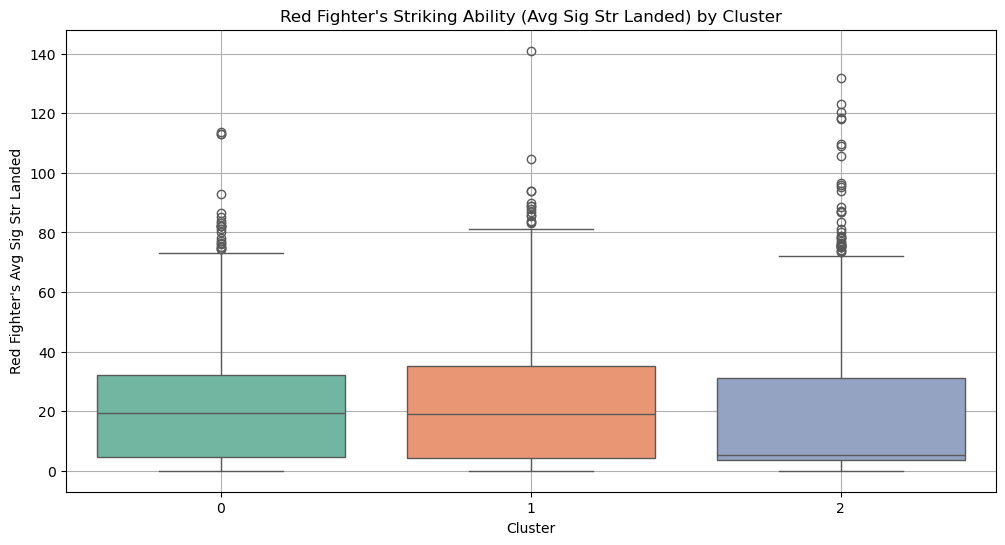

C:\Users\mauro\AppData\Local\Temp\ipykernel_4452\1772944671.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="BlueAvgSigStrLanded", data=UFC_df, palette="Set2")


<Figure size 640x480 with 0 Axes>

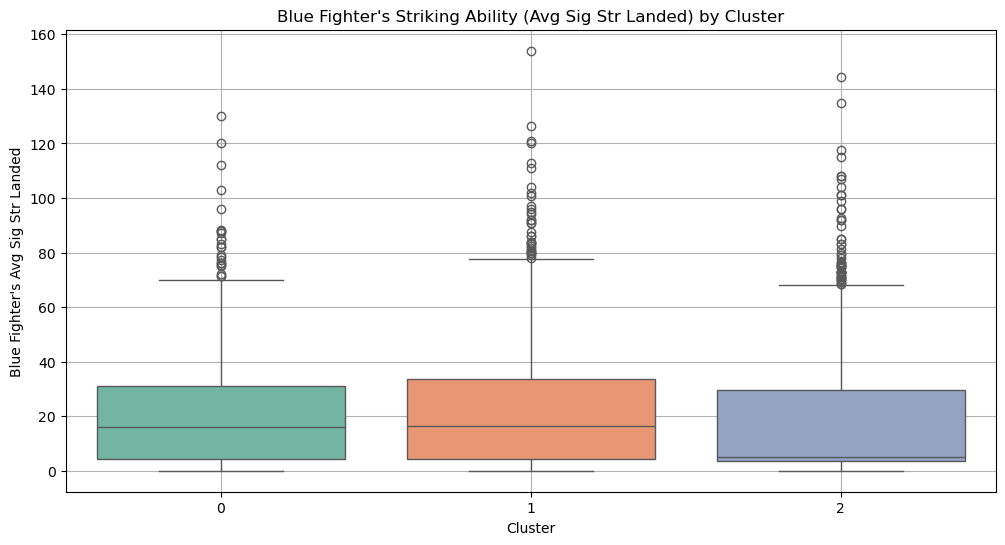

C:\Users\mauro\AppData\Local\Temp\ipykernel_4452\1772944671.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="RedAvgTDPct", data=UFC_df, palette="Set2")


<Figure size 640x480 with 0 Axes>

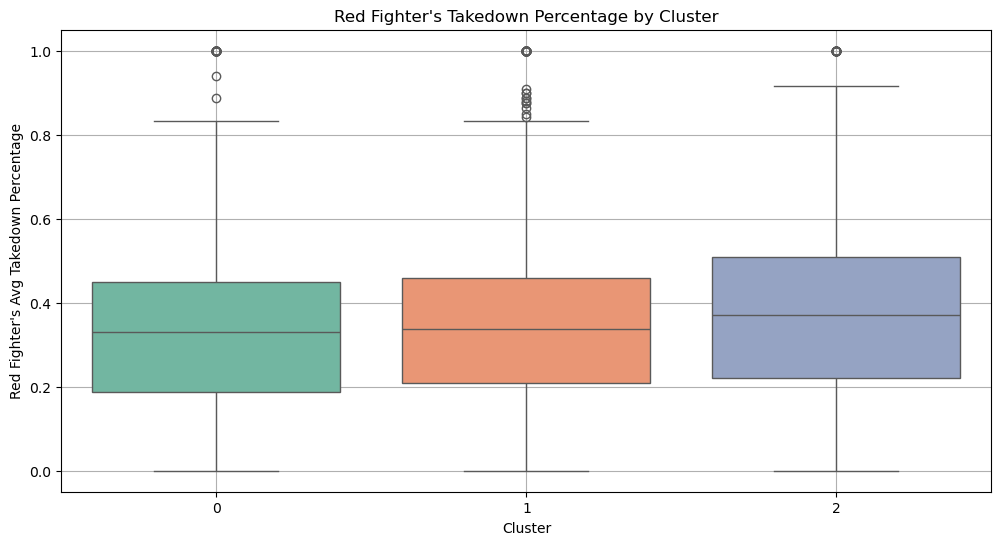

C:\Users\mauro\AppData\Local\Temp\ipykernel_4452\1772944671.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="BlueAvgTDPct", data=UFC_df, palette="Set2")


<Figure size 640x480 with 0 Axes>

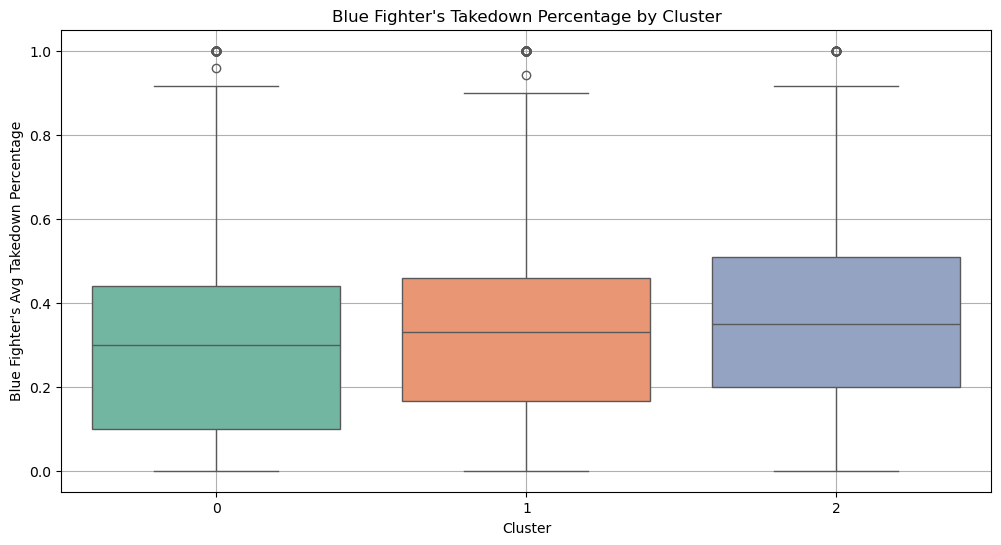

<Figure size 640x480 with 0 Axes>

In [16]:
# Boxplot for Red Fighter's Striking Ability vs Takedown Percentage by Cluster
plt.figure(figsize=(12, 6))

sns.boxplot(x="Cluster", y="RedAvgSigStrLanded", data=UFC_df, palette="Set2")
plt.title("Red Fighter's Striking Ability (Avg Sig Str Landed) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Red Fighter's Avg Sig Str Landed")
plt.grid(True)
plt.show()

# save
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "RedFighter_StrikingAbility_Kmeans_clusters.png",
    )
)

# Boxplot for Blue Fighter's Striking Ability vs Takedown Percentage by Cluster
plt.figure(figsize=(12, 6))

sns.boxplot(x="Cluster", y="BlueAvgSigStrLanded", data=UFC_df, palette="Set2")
plt.title("Blue Fighter's Striking Ability (Avg Sig Str Landed) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Blue Fighter's Avg Sig Str Landed")
plt.grid(True)
plt.show()

# save it
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "BlueFighter_StrikingAbility_Kmeans_clusters.png",
    )
)

# Boxplot for Red Fighter's Takedown Percentage by Cluster
plt.figure(figsize=(12, 6))

sns.boxplot(x="Cluster", y="RedAvgTDPct", data=UFC_df, palette="Set2")
plt.title("Red Fighter's Takedown Percentage by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Red Fighter's Avg Takedown Percentage")
plt.grid(True)
plt.show()

# save it
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "RedFighter_TakedownPercentage_Kmeans_clusters.png",
    )
)

# Boxplot for Blue Fighter's Takedown Percentage by Cluster
plt.figure(figsize=(12, 6))

sns.boxplot(x="Cluster", y="BlueAvgTDPct", data=UFC_df, palette="Set2")
plt.title("Blue Fighter's Takedown Percentage by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Blue Fighter's Avg Takedown Percentage")
plt.grid(True)
plt.show()

# save it
plt.savefig(
    os.path.join(
        path,
        "04 Analysis",
        "Visualizations",
        "BlueFighter_TakedownPercentage_Kmeans_clusters.png",
    )
)

### Cluster Analysis: Striking Ability vs Takedown Percentage

The boxplots reveal distinct differences across clusters in terms of **striking ability** (average significant strikes landed) and **takedown percentage**. Here’s a breakdown of the clusters:

#### **Red Fighter's Striking Ability (Avg Sig Str Landed) by Cluster**
- **Cluster 0**: This cluster shows a relatively **low** average for **RedAvgSigStrLanded**. Fighters in this cluster tend to rely less on striking and may prefer other strategies.
- **Cluster 1**: The significant strikes landed are **medium to low**, suggesting that fighters in this cluster balance striking with other techniques, possibly including grappling or control.
- **Cluster 2**: This cluster has the **highest** values for **RedAvgSigStrLanded**, indicating that these fighters are **highly aggressive strikers**, focusing primarily on striking.

#### **Blue Fighter's Striking Ability (Avg Sig Str Landed) by Cluster**
- **Cluster 0**: Like the Red Fighter in Cluster 0, Blue Fighters in this cluster have a **low** average of **BlueAvgSigStrLanded**, again indicating a reliance on other techniques.
- **Cluster 1**: This cluster has a **medium** level of significant strikes landed, suggesting a **balanced approach** between striking and other fighting styles.
- **Cluster 2**: Blue Fighters in this cluster also have a **higher average of significant strikes**, highlighting their **focus on aggressive striking**.

#### **Red Fighter's Takedown Percentage by Cluster**
- **Cluster 0**: This cluster shows a **low** to **medium** **takedown percentage**, meaning fighters in this cluster likely rely more on striking or other techniques rather than grappling.
- **Cluster 1**: Fighters in this cluster have a **higher** median for **RedAvgTDPct**, indicating a greater focus on **grappling** and takedowns, although still with some striking ability.
- **Cluster 2**: This cluster also shows a **higher** median for **takedown percentage**, but it is slightly lower than Cluster 1. This could imply a **balanced mix** of both striking and grappling.

#### **Blue Fighter's Takedown Percentage by Cluster**
- **Cluster 0**: Similar to Cluster 0 for Red Fighters, **BlueAvgTDPct** is **low** to **medium**, indicating that these fighters likely focus more on striking.
- **Cluster 1**: Blue Fighters in Cluster 1 show a **higher** and more **consistent** takedown percentage, indicating that grappling plays a stronger role for them.
- **Cluster 2**: This cluster also has **higher** takedown percentages, although the spread is wider than Cluster 1. Fighters in this cluster might have a more **balanced mix** of both striking and grappling.

### Interpretation Summary:
- **Cluster 0**: Represents **striking-focused fighters**, with lower takedown percentages and significant strikes. These fighters likely end fights quickly, often through **KO/TKO**.
- **Cluster 1**: This cluster contains **balanced fighters**, with a mix of **striking** and **grappling** (both average takedown percentage and significant strikes).
- **Cluster 2**: Fighters in this cluster are **aggressive strikers**, with a focus on striking, but they still possess a relatively solid **grappling** game.


## Descriptive statistics

In [17]:
# Re-encode selected categorical columns to ensure they're numeric

encoded_cols = ["Finish", "WeightClass", "RedStance", "BlueStance", "Gender", "Winner"]
for col in encoded_cols:
    if UFC_df[col].dtype == "object":
        le = LabelEncoder()
        UFC_df[col] = le.fit_transform(UFC_df[col])

# Now compute the cluster-wise mean on those features + numericals
selected_features = [
    "Finish",
    "WeightClass",
    "RedStance",
    "BlueStance",
    "TotalFightTimeSecs",
    "FinishRound",
    "RedReachCms",
    "BlueReachCms",
    "RedAge",
    "BlueAge",
    "RedAvgSigStrLanded",
    "BlueAvgSigStrLanded",
    "RedAvgTDPct",
    "BlueAvgTDPct",
    "Gender",
    "Winner",
    "ReachDiff",
    "StanceDiff",
]

UFC_df.groupby("Cluster")[selected_features].mean()

,Finish,WeightClass,RedStance,BlueStance,TotalFightTimeSecs,FinishRound,RedReachCms,BlueReachCms,RedAge,BlueAge,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgTDPct,BlueAvgTDPct,Gender,Winner,ReachDiff,StanceDiff
Cluster,,,,,,,,,,,,,,,,,,
0,2.693657,4.938372,1.339631,1.345029,275.282051,1.385065,186.123477,185.776343,30.499775,29.966712,21.325386,19.657998,0.327919,0.301208,1.000000,0.571750,0.347135,0.576698
1,1.551527,4.644590,1.317728,1.336569,916.638025,3.119612,183.582272,183.479361,30.344847,29.731659,21.919882,21.114352,0.339683,0.323684,1.000000,0.587496,0.102912,0.595490
2,1.899002,10.820449,1.182045,1.189526,773.408978,2.713217,167.004389,166.390948,30.034913,29.682045,19.653275,18.855399,0.377862,0.368925,0.001247,0.571072,0.613441,0.730673


In [18]:
# Print all encoded mappings
for col, le in label_encoders.items():
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Gender encoding: {'FEMALE': 0, 'MALE': 1}
Winner encoding: {'Blue': 0, 'Red': 1}
RedStance encoding: {'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3}
BlueStance encoding: {'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3, 'Switch ': 4, 'Unknown': 5}
Finish encoding: {'DQ': 0, 'Decision': 1, 'KO/TKO': 2, 'Overturned': 3, 'SUB': 4, 'Unknown': 5}
WeightClass encoding: {'Bantamweight': 0, 'Catch Weight': 1, 'Featherweight': 2, 'Flyweight': 3, 'Heavyweight': 4, 'Light Heavyweight': 5, 'Lightweight': 6, 'Middleweight': 7, 'Welterweight': 8, "Women's Bantamweight": 9, "Women's Featherweight": 10, "Women's Flyweight": 11, "Women's Strawweight": 12}


### **Cluster Interpretation Based on Descriptive Statistics**

The following interpretation is based on the **mean values** for each cluster, using features such as **finish type**, **weight class**, **fighter stances**, **fight duration**, **reach**, and **takedown percentage**.

#### **Cluster 0**
- **Finish**: The most common finish type in this cluster is **KO/TKO** (encoded as 2), suggesting that fighters in this cluster are aggressive and likely finish their fights quickly.
- **WeightClass**: The average weight class for this cluster is **4.94**, which corresponds to fighters primarily in the **Lightweight** and **Middleweight** divisions.
- **Stance**: Both **RedStance** and **BlueStance** have average values around **1.34**, which indicates a mix of **Orthodox** and **Southpaw** fighters in this group.
- **Fight Duration**: The average fight time is **short** (~275 seconds), meaning these fights tend to end quickly, possibly by knockout or submission.
- **Reach**: Fighters in this cluster have **balanced reach** (Red reach = 186 cm, Blue reach = 185 cm), with minimal difference in reach between the red and blue fighters.
- **Age**: The average age for both **Red** and **Blue** fighters in this cluster is around **30.5 years**, indicating a mature group of fighters.
- **Takedown Percentage**: Both the **Red** and **Blue** fighters in this cluster have **moderate** takedown percentages, with Red fighters having a slightly higher average than Blue fighters. This suggests a mix of grappling and striking styles.

#### **Cluster 1**
- **Finish**: The average finish type for this cluster is **Decision** (encoded as 1), indicating that these fights are more likely to go the distance and be decided by judges’ scorecards.
- **WeightClass**: Fighters in this cluster tend to be in the **Lightweight** to **Welterweight** divisions, with an average weight class of **4.64**.
- **Stance**: The average **RedStance** is **1.32**, and the **BlueStance** is **1.34**, suggesting a higher likelihood of **Orthodox** stance for both fighters in this group.
- **Fight Duration**: The average fight duration is **long** (~917 seconds), implying that the fights are more strategic and go the full distance.
- **Reach**: Fighters in this cluster tend to have a **balanced reach**, with average values of **183.58 cm** (Red) and **183.48 cm** (Blue), indicating similar reach.
- **Age**: The average age for both **Red** and **Blue** fighters is **around 30.3 years**, indicating that these are experienced fighters.
- **Takedown Percentage**: This cluster shows a **higher** average for **takedown percentage** than Cluster 0, with **Red** fighters having an average of **0.34** and **Blue** fighters averaging **0.32**. This suggests more focus on grappling.

#### **Cluster 2**
- **Finish**: The finish type for this cluster is predominantly **KO/TKO** (encoded as 2) and **Submission** (encoded as 4), suggesting that these fights are a mix of quick knockouts and submission finishes.
- **WeightClass**: Fighters in this cluster tend to belong to the **Heavyweight** division (encoded as 4), with an average weight class of **10.82**.
- **Stance**: The average **RedStance** is **1.18** and **BlueStance** is **1.19**, indicating a **dominance of Orthodox** stance for both fighters.
- **Fight Duration**: The average fight time is **moderate** (~773 seconds), suggesting these fighters go for both tactical and aggressive strategies, possibly a mix of striking and grappling.
- **Reach**: Fighters in this cluster have the **lowest average reach** compared to other clusters, with **Red reach** at **167 cm** and **Blue reach** at **166 cm**.
- **Age**: The average age for **Red** and **Blue** fighters is around **30 years**, which is consistent with the other clusters.
- **Takedown Percentage**: Takedown percentages in this cluster are **relatively low**, with **Red** fighters averaging **0.37** and **Blue** fighters averaging **0.37**. This suggests less focus on grappling compared to striking.


### **Conclusion**
- **Cluster 0**: Represents **aggressive fighters** who rely on striking, with shorter fights that often end in **KO/TKO**.
- **Cluster 1**: Represents **balanced fighters**, with a mix of **striking** and **grappling**, and **longer, decision-based** fights.
- **Cluster 2**: Fighters here are a mix of **knockout artists and submission specialists**, with slightly **lower reach** and **moderate fight durations**.

These clusters can be useful for:
- **Matchmaking**: Identifying fighter types based on their preferred tactics.
- **Fight Outcome Predictions**: Clusters can help predict outcomes based on fighting styles.
- **Performance Insights**: Understanding what strategies work best based on clustering results.


### **Future Use of Clustering Results in Analytics Pipeline**

The clustering analysis conducted on fighter features such as **striking ability**, **takedown percentage**, **reach difference**, and **fight duration** provides a **clearer understanding** of the different types of fighters in the UFC. These results can be extremely useful for **future steps** in the analytics pipeline, including:

#### **1. Fight Outcome Prediction**
- **Cluster 0** (KO/TKO fighters) could indicate a **predictive model for quick finishes**. If a fighter belongs to this cluster, there is a higher probability that they will win via KO/TKO. 
- **Cluster 1** (balanced fighters) might indicate **longer, more tactical fights**, where decisions are more likely. This can help predict fight outcomes based on fighter tendencies (aggressive vs. strategic).
- **Cluster 2** (submission or knockout specialists) can help identify fighters who excel in specific finish types (either **KO/TKO** or **Submission**), providing insights into **how the fight might play out**.

#### **2. Matchmaking Strategy**
- By clustering fighters based on their **styles** (e.g., **aggressive** vs. **technical**), UFC matchmakers can create **more engaging fights** by pairing fighters with **similar or contrasting fighting styles**. 
- For example, a fight between a **KO/TKO fighter (Cluster 0)** and a **technical decision fighter (Cluster 1)** would create **dynamic and unpredictable matchups**.
- **Cluster 2**, with its balanced mix of striking and grappling, might be paired with another versatile fighter to create a **well-rounded** match.

#### **3. Fighter Development**
- Fighters in **Cluster 0** may need to work on their **grappling** or **endurance** to evolve beyond pure striking, helping coaches **design tailored training programs**.
- **Cluster 1** fighters, with a mix of techniques, might benefit from further improving their **striking** or **takedown defense**, enabling them to be more **dynamic** in the octagon.
- Fighters in **Cluster 2**, with their focus on **submissions and KO/TKO**, can be trained to **hone their wrestling and submissions**, possibly making them **more well-rounded** and adaptable against a wider range of opponents.

#### **4. Fan Engagement and Marketing**
- The insights from clusters can also be used to create targeted **fan engagement** strategies. For instance, fans might be more excited about **Cluster 0** fighters who deliver **exciting KO/TKO finishes** in shorter bouts. 
- Fighters from **Cluster 2**, with a combination of finishes, could be marketed as **versatile fighters**, appealing to a broader fanbase.
  
#### **5. Longitudinal Analysis and Strategy Optimization**
- By analyzing how **fighter styles** (from different clusters) evolve over time, analysts can identify trends such as **changes in strategy**, improvements in **takedown defense**, or an increase in **striking** focus.
- For example, if a fighter in **Cluster 1** starts to shift towards more **KO/TKO finishes**, it might indicate an evolving style that requires **strategic adjustments**.
  
#### **6. Enhancing Fighter Analytics for Coaches and Trainers**
- With clear clustering results, **coaches** can assess what strategies work for specific types of fighters. For instance, coaches of **Cluster 0** fighters may emphasize **speed and power** training, while coaches of **Cluster 1** fighters may focus on **tactical control** and endurance.
- **Cluster 2** fighters, being a mix of striking and grappling, can focus on improving **well-rounded skills** to ensure adaptability against different types of opponents.

### Conclusion
The insights from the clustering analysis can guide a range of **strategic decisions** in both **fight preparation** and **matchmaking**, while also contributing to **predictive models** for fight outcomes. By incorporating these insights into the **analytics pipeline**,
